In [1]:
import os
import h5py
import pandas as pd
from pathlib import Path
from harp_resources import process, utils

In [2]:
mouse_info = {'B2M1': {'sex': 'M', 'area': 'V2M'},
              'B2M4': {'sex': 'M', 'area': 'V2M'},
              'B2M5': {'sex': 'M', 'area': 'V2M'},
              'B2M6': {'sex': 'M', 'area': 'V2M'},
              'B3M1': {'sex': 'M', 'area': 'V2M'},
              'B3M2': {'sex': 'M', 'area': 'V2M'},
              'B3M3': {'sex': 'F', 'area': 'V1'},
              'B3M4': {'sex': 'M', 'area': 'V2M'},
              'B3M5': {'sex': 'M', 'area': 'V2M'},
              'B3M6': {'sex': 'F', 'area': 'V2M'},
              'B3M7': {'sex': 'F', 'area': 'V2M'},
              'B3M8': {'sex': 'F', 'area': 'V2M'},
             }

session_info = {'220824': 'day1',
                '230824': 'day2',
                '190824': 'day1',
                '200824': 'day2',
                '120824': 'day1',
                '130824': 'day2',
                '070824': 'day1',
                '080824': 'day2',
               }

In [3]:
def load_streams_from_h5s(data_paths):
    '''
    Takes list of H5 file paths and, loads streams into dictionary, and save to dictionary named by mouse ID
    '''
    #dict to save streams:
    reconstructed_dict = {} 
    # File path to read the HDF5 file
    for input_file in data_paths:
        name = input_file.split('/')[-1][-7:-3] # Given that file name is of format: resampled_streams_2024-08-22T13-13-15_B3M6.h5 
        
        if not os.path.exists(input_file):
            print(f'ERROR: {input_file} does not exist.')
            return None
    
        # Open the HDF5 file to read data
        with h5py.File(input_file, 'r') as h5file:
            print(f'reconstructing streams for mouse {input_file.split('/')[-1][-7:-3]}, from session folder: {input_file.split('/')[-3]}')
            # Read the common index (which was saved as Unix timestamps)
            common_index = h5file['HARP_timestamps'][:]
            
            # Convert Unix timestamps back to pandas DatetimeIndex
            # common_index = pd.to_datetime(common_index)
            
            # Initialize the dictionary to reconstruct the data
            reconstructed_streams = {}
            
            # Iterate through the groups (sources) in the file
            for source_name in h5file.keys():
                if source_name == 'HARP_timestamps':
                    # Skip the 'common_index' dataset, it's already loaded
                    continue
                
                # Initialize a sub-dictionary for each source
                reconstructed_streams[source_name] = {}
                
                # Get the group (source) and iterate over its datasets (streams)
                source_group = h5file[source_name]
                
                for stream_name in source_group.keys():
                    # Read the stream data
                    stream_data = source_group[stream_name][:]
                    
                    # Reconstruct the original pd.Series with the common index
                    reconstructed_streams[source_name][stream_name] = pd.Series(data=stream_data, index=common_index)
                
        reconstructed_dict[name] = reconstructed_streams
        print(f'  --> {input_file.split('/')[-1][-7:-3]} streams reconstructed and added to dictionary \n')
            

    return reconstructed_dict

## Defining paths for grab or G8

In [4]:
sensor = 'grab' #'grab' or 'g8'

In [5]:
rootdir = '/Volumes/RanczLab/20240730_Mismatch_Experiment/GRAB_MMclosed-and-open_190824'
h5_paths = []
eventpaths = []
for dirpath, subdirs, files in os.walk(rootdir):
    for x in files:
        if '.h5' in x:
            eventpaths.append(dirpath)
            h5_paths.append(dirpath+'/'+x)

In [6]:
'''if sensor == 'grab':
    paths = ['/Users/hildeteigen/Downloads/resampled_streams_2024-08-22T13-13-15_B3M6.h5']
    eventpaths = ['/Volumes/RanczLab/20240730_Mismatch_Experiment/GRAB_MMclosed-and-Regular_220824/2024-08-22T13-13-15_B3M6'] 
    
if sensor == 'g8':
    paths = ['/Users/hildeteigen/Downloads/resampled_streams_2024-08-22T13-13-15_B3M6.h5']
    eventpaths = ['/Volumes/RanczLab/20240730_Mismatch_Experiment/GRAB_MMclosed-and-Regular_220824/2024-08-22T13-13-15_B3M6'] '''

"if sensor == 'grab':\n    paths = ['/Users/hildeteigen/Downloads/resampled_streams_2024-08-22T13-13-15_B3M6.h5']\n    eventpaths = ['/Volumes/RanczLab/20240730_Mismatch_Experiment/GRAB_MMclosed-and-Regular_220824/2024-08-22T13-13-15_B3M6'] \n    \nif sensor == 'g8':\n    paths = ['/Users/hildeteigen/Downloads/resampled_streams_2024-08-22T13-13-15_B3M6.h5']\n    eventpaths = ['/Volumes/RanczLab/20240730_Mismatch_Experiment/GRAB_MMclosed-and-Regular_220824/2024-08-22T13-13-15_B3M6'] "

### Loading data streams

In [7]:
stream_dict_dict = load_streams_from_h5s(h5_paths)

reconstructing streams for mouse B2M6, from session folder: GRAB_MMclosed-and-open_190824
  --> B2M6 streams reconstructed and added to dictionary 

reconstructing streams for mouse B3M8, from session folder: GRAB_MMclosed-and-open_190824
  --> B3M8 streams reconstructed and added to dictionary 

reconstructing streams for mouse B3M7, from session folder: GRAB_MMclosed-and-open_190824
  --> B3M7 streams reconstructed and added to dictionary 

reconstructing streams for mouse B3M6, from session folder: GRAB_MMclosed-and-open_190824
  --> B3M6 streams reconstructed and added to dictionary 

reconstructing streams for mouse B3M4, from session folder: GRAB_MMclosed-and-open_190824
  --> B3M4 streams reconstructed and added to dictionary 



In [8]:
stream_dict_dict['B3M8']['H1']

{'OpticalTrackingRead0X(46)': 92979.0756    0.000000
 92979.0757    0.043638
 92979.0758    0.087276
 92979.0759    0.130914
 92979.0760    0.174553
                 ...   
 94915.9554    0.000499
 94915.9555    0.000374
 94915.9556    0.000249
 94915.9557    0.000125
 94915.9558    0.000000
 Length: 19368803, dtype: float64,
 'OpticalTrackingRead0Y(46)': 92979.0756    0.000000
 92979.0757    0.020766
 92979.0758    0.041533
 92979.0759    0.062299
 92979.0760    0.083066
                 ...   
 94915.9554    0.000183
 94915.9555    0.000137
 94915.9556    0.000091
 94915.9557    0.000046
 94915.9558    0.000000
 Length: 19368803, dtype: float64}

In [27]:
data_dict = {}
for mouse, streamdict in stream_dict_dict.items():
    #Getting fluorescence traces
    fluorescence = streamdict['Photometry']['470_dfF'] #Using '470_dfF' only

    #Getting mouse movement data and converting to cm / second
    movementX = process.running_unit_conversion(streamdict['H1']['OpticalTrackingRead0X(46)'])*100
    movementY = process.running_unit_conversion(streamdict['H1']['OpticalTrackingRead0Y(46)'])*100

    #Getting eye movements and pupil diameter
    #eye_center_x = streamdict['SleapVideoData2']['Ellipse.Center.X']
    #eye_center_y = streamdict['SleapVideoData2']['Ellipse.Center.Y']
    #eye_diameter = streamdict['SleapVideoData2']['Ellipse.Diameter']

    #Getting visual stimuli event times
    event = streamdict['ONIX']['Photodiode']
    
    time = movementX.index - movementX.index[0]
    
    dict = {'470_dfF': fluorescence, 'movementX': movementX, 'movementY': movementY, 'event': event,
        'Seconds': time}
    #dict = {'470_dfF': fluorescence, 'movementX': movementX, 'movementY': movementY, 'event': event,
     #   'TimeStamp': time, 'eye_x': eye_center_x, 'eye_y': eye_center_y, 'pupil_diameter': eye_diameter}

    df = pd.DataFrame(dict)

    #Reversing, so that a halt appearst when 'event'==True
    df['event'] = ~df['event']
    
    df.reset_index(inplace=False)
    
    data_dict[mouse] = df

In [28]:
data_dict['B3M7']

,470_dfF,movementX,movementY,event,Seconds
95487.9626,0.000000,0.000000,0.000000,True,0.0000
95487.9627,0.000342,0.000743,0.000203,True,0.0001
95487.9628,0.000683,0.001486,0.000405,True,0.0002
95487.9629,0.001025,0.002228,0.000608,True,0.0003
95487.9630,0.001366,0.002971,0.000811,True,0.0004
...,...,...,...,...,...
97423.4075,0.000052,0.000268,-0.000061,False,1935.4449
97423.4076,0.000039,0.000201,-0.000046,False,1935.4450
97423.4077,0.000026,0.000134,-0.000031,False,1935.4451
97423.4078,0.000013,0.000067,-0.000015,False,1935.4452


### Loading Experiment events and session info

In [29]:
event_dict = {}
for eventpath in eventpaths:
    ExpEvents = utils.read_ExperimentEvents(Path(eventpath))
    ExpEvents.set_index('Seconds', inplace = True)
    ExpEvents.index = ExpEvents.index.round(4)
    name = eventpath.split('/')[-1][-4:]
    ExpEvents['experiment'] = eventpath.split('/')[-2].split('_')[1]
    for key, item in session_info.items():
        if key in eventpath.split('/')[-2]:
            ExpEvents['session']=item
    event_dict[name] = ExpEvents



File names:  ['ExperimentEvents_1904-01-02T01-00-00.csv'] 


File names:  ['ExperimentEvents_1904-01-02T01-00-00.csv', 'ExperimentEvents_1904-01-02T02-00-00.csv'] 


File names:  ['ExperimentEvents_1904-01-02T02-00-00.csv', 'ExperimentEvents_1904-01-02T03-00-00.csv'] 


File names:  ['ExperimentEvents_1904-01-02T03-00-00.csv'] 


File names:  ['ExperimentEvents_1904-01-02T03-00-00.csv', 'ExperimentEvents_1904-01-02T04-00-00.csv'] 



/Users/hildeteigen/Documents/GitHub/vestibular_vr_pipeline/harp_resources/utils.py:48: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sorted_filenames = pd.to_datetime(pd.Series([x.split('_')[1].split('.')[0] for x in filenames])).sort_values()
/Users/hildeteigen/Documents/GitHub/vestibular_vr_pipeline/harp_resources/utils.py:48: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sorted_filenames = pd.to_datetime(pd.Series([x.split('_')[1].split('.')[0] for x in filenames])).sort_values()
/Users/hildeteigen/Documents/GitHub/vestibular_vr_pipeline/harp_resources/utils.py:48: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and

### Adding events (and non-events) and session info to data

In [48]:
def add_experiment_events(data_dict, events_dict):
    # Iterate over each mouse in the dictionaries
    for mouse_key in data_dict:
        main_df = data_dict[mouse_key]  # Large DataFrame (main data)
        event_df = events_dict[mouse_key]  # Small DataFrame (event data)

        # Ensure the index of the event_df is named 'Seconds' and has proper precision
        event_df.index.name = 'Seconds'
        
        # Resolve duplicate index values by keeping the first occurrence or handling them accordingly
        event_df = event_df[~event_df.index.duplicated(keep='first')]
        
        # Ensure the same for the main_df, if there are duplicates
        main_df = main_df[~main_df.index.duplicated(keep='first')]
        
        # Use pd.merge_asof to match the nearest milliseconds from main_df index to event_df index
        merged_df = pd.merge_asof(
            main_df,
            event_df[['Value']],  # Only bring in the 'Value' column
            left_index=True,  # main_df has time in its index
            right_index=True,  # event_df has time in its index (both in ms)
            direction='backward',  # Choose the closest event on or before the timestamp
            tolerance=0.005 # Adjust tolerance for closest matching (to milliseconds)
        )
        
        # Add 'ExperimentEvents' column to main_df from merged_df
        main_df['ExperimentEvents'] = merged_df['Value']
        
        # Add metadata from event_df
        main_df['Experiment'] = event_df['experiment'].unique()[0]
        main_df['Session'] = event_df['session'].unique()[0]
        
        # Add mouse ID, sex, and brain area
        main_df['mouseID'] = mouse_key
        main_df['sex'] = mouse_info[mouse_key]['sex']
        main_df['area'] = mouse_info[mouse_key]['area']
        
        # Update the dictionary with the modified DataFrame
        data_dict[mouse_key] = main_df
        
        print(f'Events and experiment info added to {mouse_key}')

    return data_dict


In [49]:
data_dict = add_experiment_events(data_dict, event_dict)

Events and experiment info added to B2M6
Events and experiment info added to B3M8
Events and experiment info added to B3M7
Events and experiment info added to B3M6
Events and experiment info added to B3M4


In [50]:
data_dict['B3M6'].ExperimentEvents.unique()


array([nan, 'Sync signal started', 'LinearMismatch block started',
       'Homing platform', 'Wait for run threshold...',
       'Check halt probability', 'Apply halt: 1s', 'Block timer elapsed'],
      dtype=object)

In [51]:
def add_no_halt_column(data_dict, events_dict):
    # Iterate over each mouse in the dictionaries
    for mouse_key in data_dict:
        main_df = data_dict[mouse_key]  # Large DataFrame
        event_df = events_dict[mouse_key]  # Small DataFrame

        # Ensure the index of the event_df is named 'Seconds' and is numeric (milliseconds)
        event_df.index.name = 'Seconds'

        # Create a new column 'No_halt' in the main_df
        main_df['No_halt'] = False

        # Filter the 'No halt' events from event_df
        no_halt_events = event_df[event_df['Value'] == 'No halt']

        # Use pd.merge_asof to match the nearest milliseconds from main_df index to event_df index
        merged_df = pd.merge_asof(
            main_df,
            no_halt_events[['Value']],  # Only bring in the 'Value' column where 'No halt' appears
            left_index=True,  # main_df has time in its index
            right_index=True,  # no_halt_events has time in its index (both in ms)
            direction='backward',  # Choose closest event on or before the timestamp
            tolerance=0.00005  # Because the dfs generally match down to 4 decimals, and we only want one no_halt at a time
        )

        # Assign True to the 'No_halt' column where 'No halt' matches
        main_df['No_halt'] = merged_df['Value'].fillna(False) == 'No halt'

        # Update the dictionary with the modified DataFrame
        data_dict[mouse_key] = main_df

        print('No_halt events added to', mouse_key)

    return data_dict


In [52]:
data_dict = add_no_halt_column(data_dict, event_dict)

No_halt events added to B2M6
No_halt events added to B3M8
No_halt events added to B3M7
No_halt events added to B3M6
No_halt events added to B3M4


In [53]:
#Check that number of no halts matches
def no_halt_len(mouse):

    event_len = len(event_dict[mouse].loc[event_dict[mouse].Value == 'No halt'])
    data_len = len(data_dict[mouse].loc[data_dict[mouse].No_halt == True])
    if event_len != data_len:
        print(f'for {mouse} the number of actual no-halt events is {event_len} and the number of True values in the data now is {data_len}')
        
    if event_len == data_len:
        print(f'Correct number of no-halt events for {mouse}')


In [54]:
for mouse in data_dict:
    no_halt_len(mouse)

Correct number of no-halt events for B2M6
Correct number of no-halt events for B3M8
Correct number of no-halt events for B3M7
Correct number of no-halt events for B3M6
Correct number of no-halt events for B3M4


In [55]:
#Adds separate columns for the different blocks 
def add_block_columns(df):
    for event in df['ExperimentEvents'].unique():

        if 'block started' in str(event):
            name = f'{event.split()[0]}_block'
            df[name] = False
                
            # Get the indices where '... block started' appears in the 'ExperimentEvents' column
            start_indices = df.index[df['ExperimentEvents'] == event].tolist()
    
            # Get the indices where 'Block Timer elapsed' appears in the 'ExperimentEvents' column
            end_indices = df.index[df['ExperimentEvents'] == 'Block timer elapsed'].tolist()
            # Pair the start and end indices together to form ranges
            end_idx = 0  # This will track the end indices
            for start_idx in start_indices:
                # Find the first 'Block Timer elapsed' after the current start index
                while end_idx < len(end_indices) and end_indices[end_idx] <= start_idx:
                    end_idx += 1
                
                # If we find a valid end index after the start index, fill the range with True
                if end_idx < len(end_indices):
                    df.loc[start_idx:end_indices[end_idx], name] = True
            print(name, 'added')
            
    return df


In [56]:
for name, df in data_dict.items():
    print('updating data for ', name)
    blocks_added_df = add_block_columns(df)
    data_dict[name] = blocks_added_df

updating data for  B2M6
LinearMismatch_block added
LinearPlaybackMismatch_block added
updating data for  B3M8
LinearMismatch_block added
updating data for  B3M7
LinearMismatch_block added
LinearPlaybackMismatch_block added
updating data for  B3M6
LinearMismatch_block added
updating data for  B3M4
LinearMismatch_block added


In [57]:
data_dict['B3M6'].loc[data_dict['B3M6'].LinearMismatch_block==True]

,470_dfF,movementX,movementY,event,Seconds,ExperimentEvents,Experiment,Session,mouseID,sex,area,No_halt,LinearMismatch_block
98052.4102,-0.148346,-0.000896,0.005134,True,6.2515,LinearMismatch block started,MMclosed-and-open,day1,B3M6,F,V2M,False,True
98052.4103,-0.148260,-0.000905,0.005083,True,6.2516,LinearMismatch block started,MMclosed-and-open,day1,B3M6,F,V2M,False,True
98052.4104,-0.148174,-0.000914,0.005031,True,6.2517,LinearMismatch block started,MMclosed-and-open,day1,B3M6,F,V2M,False,True
98052.4105,-0.148088,-0.000923,0.004980,True,6.2518,LinearMismatch block started,MMclosed-and-open,day1,B3M6,F,V2M,False,True
98052.4106,-0.148002,-0.000932,0.004929,True,6.2519,LinearMismatch block started,MMclosed-and-open,day1,B3M6,F,V2M,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
98993.4859,-0.741297,0.144287,0.028237,False,947.3272,NaN,MMclosed-and-open,day1,B3M6,F,V2M,False,True
98993.4860,-0.741245,0.144131,0.028237,False,947.3273,NaN,MMclosed-and-open,day1,B3M6,F,V2M,False,True
98993.4861,-0.741193,0.143974,0.028237,False,947.3274,NaN,MMclosed-and-open,day1,B3M6,F,V2M,False,True
98993.4862,-0.741141,0.143817,0.028237,False,947.3275,NaN,MMclosed-and-open,day1,B3M6,F,V2M,False,True


In [59]:
data_dict['B3M6'].loc[data_dict['B3M6'].No_halt==True]
event_dict['B3M6'].loc[event_dict['B3M6'].Value=='No halt']

,Value,experiment,session
Seconds,,,
98158.9282,No halt,MMclosed-and-open,day1
98184.5108,No halt,MMclosed-and-open,day1
98262.2702,No halt,MMclosed-and-open,day1
98276.1413,No halt,MMclosed-and-open,day1
98356.2722,No halt,MMclosed-and-open,day1
...,...,...,...
99823.5277,No halt,MMclosed-and-open,day1
99836.1107,No halt,MMclosed-and-open,day1
99883.2003,No halt,MMclosed-and-open,day1


In [60]:
def downsample_data(df, time_col='Seconds', interval=0.001):
    # Convert the Seconds column to a TimedeltaIndex
    df = df.set_index(pd.to_timedelta(df[time_col], unit='s'))

    # Define aggregation functions for all possible columns
    aggregation_functions = {
        '470_dfF': 'mean',
        'movementX': 'mean',
        'movementY': 'mean',
        'event': 'any',
        'ExperimentEvents': lambda x: x.dropna().iloc[0] if not x.dropna().empty else None,
        'Experiment': 'first',
        'Session': 'first',
        'mouseID': 'first',
        'sex': 'first',
        'area': 'first',
        'No_halt': 'any',
        'LinearMismatch_block': 'any',
        'LinearPlaybackMismatch_block': 'any',
        'LinearRegular_block': 'any'
    }

    # Filter aggregation_functions to only include columns present in df
    aggregation_functions = {key: func for key, func in aggregation_functions.items() if key in df.columns}

    # Resample with the specified interval and apply the filtered aggregations
    downsampled_df = df.resample(f'{interval}s').agg(aggregation_functions)

    # Reset the index to make the Seconds column normal again
    downsampled_df = downsampled_df.reset_index()
    downsampled_df[time_col] = downsampled_df[time_col].dt.total_seconds()  # Convert Timedelta back to seconds

    # Forward fill for categorical columns if needed, only if they exist in downsampled_df
    categorical_cols = ['Experiment', 'Session', 'mouseID', 'sex', 'area']
    for col in categorical_cols:
        if col in downsampled_df.columns:
            downsampled_df[col] = downsampled_df[col].ffill()

    # Remove consecutive duplicate values in the 'ExperimentEvents' column, if it exists
    if 'ExperimentEvents' in downsampled_df.columns:
        downsampled_df['ExperimentEvents'] = downsampled_df['ExperimentEvents'].where(
            downsampled_df['ExperimentEvents'] != downsampled_df['ExperimentEvents'].shift()
        )

    return downsampled_df



In [61]:
def test_event_numbers(downsampled_data, original_data, mouse):
    nohalt_down = len(downsampled_data.loc[downsampled_data['No_halt']==True])
    nohalt_original = len(original_data.loc[original_data['No_halt']==True])
    if nohalt_down != nohalt_original:
        print(f'mouse{mouse}')
        print(f'There are actually {nohalt_original} no-halts, but the downsampled data only contains {nohalt_down}')
    
    

In [62]:
'''downsampled_dict = {}
for mouse, mouse_df in data_dict.items():
    downsampled_df = downsample_data(mouse_df, time_col='Seconds', interval=0.001)
    downsampled_dict[mouse]=downsampled_df
    test_event_numbers(downsampled_df, mouse_df, mouse)
    '''
mouse = 'B3M6'
downsampled_df = downsample_data(data_dict[mouse], time_col='Seconds', interval=0.001)
test_event_numbers(downsampled_df, data_dict[mouse], mouse)

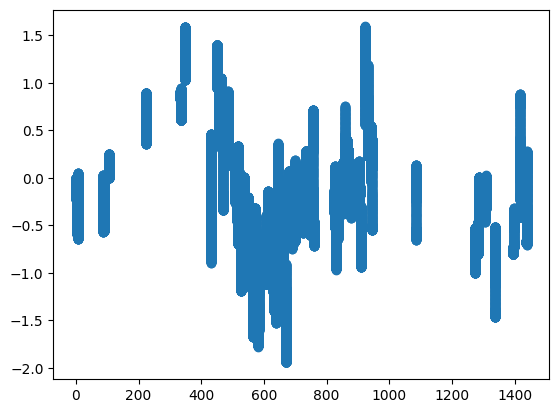

In [63]:
from matplotlib import pyplot as plt
plt.scatter(downsampled_df['Seconds'].loc[downsampled_df['event']==True], downsampled_df['470_dfF'].loc[downsampled_df['event']==True])

In [64]:

downsampled_df.ExperimentEvents.unique()#.loc[downsampled_df.No_halt==True]


array([None, 'Sync signal started', nan, 'LinearMismatch block started',
       'Homing platform', 'Wait for run threshold...',
       'Check halt probability', 'Apply halt: 1s', 'Block timer elapsed'],
      dtype=object)

In [25]:
downsampled_df#.loc[downsampled_df.No_halt==True]

downsampled_df.ExperimentEvents.unique()#.loc[downsampled_df.No_halt==True]
downsampled_df.loc[downsampled_df.ExperimentEvents=='Apply halt: 1s']


,Seconds,470_dfF,movementX,movementY,event,ExperimentEvents,Experiment,Session,mouseID,sex,area,No_halt,LinearMismatch_block
87237,87.237,-0.701991,0.000800,0.001040,False,Apply halt: 1s,MMclosed-and-open,day1,B3M6,F,V2M,False,True
104981,104.981,-0.030543,0.084742,-0.010178,False,Apply halt: 1s,MMclosed-and-open,day1,B3M6,F,V2M,False,True
223671,223.671,0.611187,0.001759,0.002477,False,Apply halt: 1s,MMclosed-and-open,day1,B3M6,F,V2M,False,True
333451,333.451,0.880891,0.122704,0.000141,False,Apply halt: 1s,MMclosed-and-open,day1,B3M6,F,V2M,False,True
346991,346.991,1.177448,0.009807,0.025773,False,Apply halt: 1s,MMclosed-and-open,day1,B3M6,F,V2M,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1336021,1336.021,-1.104694,0.160302,0.023129,False,Apply halt: 1s,MMclosed-and-open,day1,B3M6,F,V2M,False,False
1395511,1395.511,-0.625343,-0.007139,0.007650,False,Apply halt: 1s,MMclosed-and-open,day1,B3M6,F,V2M,False,False
1417296,1417.296,0.469186,-0.034449,0.000000,False,Apply halt: 1s,MMclosed-and-open,day1,B3M6,F,V2M,False,False
1426629,1426.629,0.290154,0.104312,0.018431,False,Apply halt: 1s,MMclosed-and-open,day1,B3M6,F,V2M,False,False


In [26]:
downsampled_df.loc[downsampled_df.Seconds >87.4]

,Seconds,470_dfF,movementX,movementY,event,ExperimentEvents,Experiment,Session,mouseID,sex,area,No_halt,LinearMismatch_block
87401,87.401,-0.573385,-2.240139e-06,0.000000e+00,False,None,MMclosed-and-open,day1,B3M6,F,V2M,False,True
87402,87.402,-0.572307,4.256264e-05,0.000000e+00,False,None,MMclosed-and-open,day1,B3M6,F,V2M,False,True
87403,87.403,-0.571229,8.736542e-05,0.000000e+00,False,None,MMclosed-and-open,day1,B3M6,F,V2M,False,True
87404,87.404,-0.570151,1.321682e-04,0.000000e+00,True,None,MMclosed-and-open,day1,B3M6,F,V2M,False,True
87405,87.405,-0.569074,1.769710e-04,0.000000e+00,True,None,MMclosed-and-open,day1,B3M6,F,V2M,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1920691,1920.691,0.805847,4.782139e-05,3.992000e-05,False,None,MMclosed-and-open,day1,B3M6,F,V2M,False,False
1920692,1920.692,0.810082,3.471964e-05,2.898301e-05,False,None,MMclosed-and-open,day1,B3M6,F,V2M,False,False
1920693,1920.693,0.814317,2.161789e-05,1.804603e-05,False,None,MMclosed-and-open,day1,B3M6,F,V2M,False,False
1920694,1920.694,0.818552,8.516137e-06,7.109041e-06,False,None,MMclosed-and-open,day1,B3M6,F,V2M,False,False


In [27]:
downsampled_df.loc[downsampled_df.event ==True]

,Seconds,470_dfF,movementX,movementY,event,ExperimentEvents,Experiment,Session,mouseID,sex,area,No_halt,LinearMismatch_block
0,0.000,-0.000052,0.000123,-0.000201,True,None,MMclosed-and-open,day1,B3M6,F,V2M,False,False
1,0.001,-0.000167,0.000395,-0.000647,True,None,MMclosed-and-open,day1,B3M6,F,V2M,False,False
2,0.002,-0.000282,0.000668,-0.001094,True,None,MMclosed-and-open,day1,B3M6,F,V2M,False,False
3,0.003,-0.000397,0.000941,-0.001540,True,None,MMclosed-and-open,day1,B3M6,F,V2M,False,False
4,0.004,-0.000512,0.001214,-0.001987,True,None,MMclosed-and-open,day1,B3M6,F,V2M,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1438390,1438.390,0.275359,0.160367,-0.019047,True,None,MMclosed-and-open,day1,B3M6,F,V2M,False,False
1438391,1438.391,0.275936,0.159189,-0.017943,True,None,MMclosed-and-open,day1,B3M6,F,V2M,False,False
1438392,1438.392,0.276513,0.158582,-0.016262,True,None,MMclosed-and-open,day1,B3M6,F,V2M,False,False
1438393,1438.393,0.277090,0.158089,-0.014465,True,None,MMclosed-and-open,day1,B3M6,F,V2M,False,False


In [28]:
#Data = process.pooling_data(data_dict)


In [29]:
Data = Data.reset_index()
Data = Data.drop(columns=['level_0'])  # Assuming the column name is 'level_0' after reset_index()
Data = Data.set_index('level_1')  # 'level_1' will be the numeric index part
Data.index.name = 'Time'

NameError: name 'Data' is not defined

In [ ]:
import matplotlib.pyplot as plt

plt.plot()

In [ ]:
#20240730_Mismatch_Experiment/GRAB_MMclosed-and-open_190824'
#Data.to_csv('GRAB_MMclosed_open_session1.csv', index=False)

In [ ]:
B3M7 = Data.loc[Data.mouseID=='B3M7']

In [ ]:
B3M4 = Data.loc[Data.mouseID=='B3M4']

In [ ]:
B3M4.loc[B3M4.ExperimentEvents == 'Block timer elapsed']

In [ ]:

B3M4.loc[B3M4.LinearPlaybackMismatch_block == True]